In [1]:
import xarray as xr
import xcdat as xc
import numpy as np
import xskillscore as xs

In [2]:
f_a = '/Users/zhang40/Downloads/ERA5-TREFHT-ANN-land_test_30yrs.nc' 
f_b = '/Users/zhang40/Downloads/ERA5-TREFHT-ANN-land_ref_30yrs.nc' 

In [3]:
tas_a = xr.open_dataset(f_a)
tas_b = xr.open_dataset(f_b)

In [4]:
output_grid = tas_a.regridder.grid
tas_b["mask"] = xr.where(~np.isnan(tas_b.TREFHT), 1, 0)
tas_b_regrid_bilinear = tas_b.regridder.horizontal(
            'TREFHT', output_grid, tool='xesmf', method='bilinear'
        )

tas_b_regrid_conservative_normed = tas_b.regridder.horizontal(
            'TREFHT', output_grid, tool='xesmf', method='conservative_normed'
        )

tas_b_regrid_conservative = tas_b.regridder.horizontal(
            'TREFHT', output_grid, tool='xesmf', method='conservative'
        )

In [5]:
# Verify if rmse from xs is same as simple calculation
result_xr_bilinear = xs.rmse(tas_a['TREFHT'], tas_b_regrid_conservative['TREFHT'], dim=["lat", "lon"], weights=None, skipna=True)
rmse_bilinear = np.sqrt(((tas_a['TREFHT'] -tas_b_regrid_conservative['TREFHT']) ** 2).mean(skipna=True))
print('xs. rmse bilinear', result_xr_bilinear.values, 'direct calculation', rmse_bilinear.values)

result_xr_conservative_normed = xs.rmse(tas_a['TREFHT'], tas_b_regrid_conservative_normed['TREFHT'], dim=["lat", "lon"], weights=None, skipna=True)
rmse_normed = np.sqrt(((tas_a['TREFHT'] -tas_b_regrid_conservative_normed['TREFHT']) ** 2).mean(skipna=True))
print('xs. rmse cons_normed', result_xr_conservative_normed.values, 'direct calculation', rmse_normed.values)

result_xr_conservative = xs.rmse(tas_a['TREFHT'], tas_b_regrid_conservative['TREFHT'], dim=["lat", "lon"], weights=None, skipna=True)
rmse_conserve = np.sqrt(((tas_a['TREFHT'] -tas_b_regrid_conservative['TREFHT']) ** 2).mean(skipna=True))
print('xs. rmse conserve', result_xr_conservative.values, 'direct calculation', rmse_conserve.values)


xs. rmse bilinear 2.0316942 direct calculation 2.0316942
xs. rmse cons_normed 1.8655692 direct calculation 1.8655692
xs. rmse conserve 2.0316942 direct calculation 2.0316942


In [6]:
# Calculate area-weighted integral after Conservative Normed regriding

weights = tas_b_regrid_conservative_normed.spatial.get_weights(["X", "Y"], data_var='TREFHT')
area_weighted_integral_normed = (tas_b_regrid_conservative_normed['TREFHT'].fillna(0) * weights).sum(dim=["lat", "lon"])
area_weighted_integral_normed

# Calculate area-weighted integral after Conservative regriding

weights = tas_b_regrid_conservative_normed.spatial.get_weights(["X", "Y"], data_var='TREFHT')
area_weighted_integral = (tas_b_regrid_conservative['TREFHT'].fillna(0) * weights).sum(dim=["lat", "lon"])
area_weighted_integral

# Calculate area-weighted integral of original field
tas_b = tas_b.bounds.add_missing_bounds()
weights0 = tas_b.spatial.get_weights(["X", "Y"], data_var='TREFHT')
area_weighted_integral0 = (tas_b['TREFHT'].fillna(0) * weights0).sum(dim=["lat", "lon"])
area_weighted_integral0


print('area_weighted_integral before regriding',area_weighted_integral0.values)
print('area_weighted_integral after conservative normed regriding',area_weighted_integral_normed.values)
print('area_weighted_integral after conservative regriding',area_weighted_integral.values)


area_weighted_integral before regriding 1771.0478512460697
area_weighted_integral after conservative normed regriding 1967.657722299664
area_weighted_integral after conservative regriding 1770.978281113709


/Users/zhang40/mambaforge/envs/e3sm-unified/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/zhang40/mambaforge/envs/e3sm-unified/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/zhang40/mambaforge/envs/e3sm-unified/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


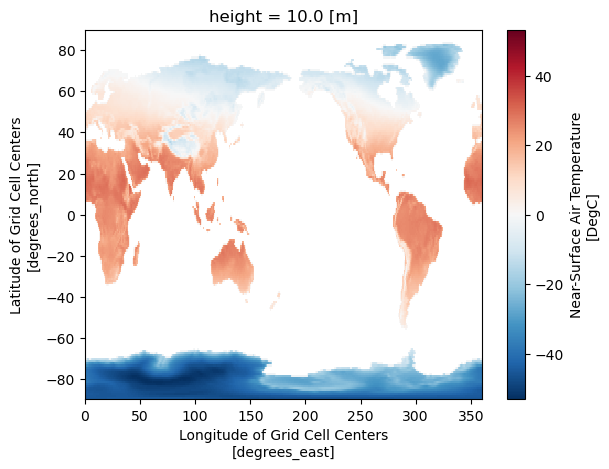

In [7]:
(tas_b_regrid_conservative.TREFHT).plot()

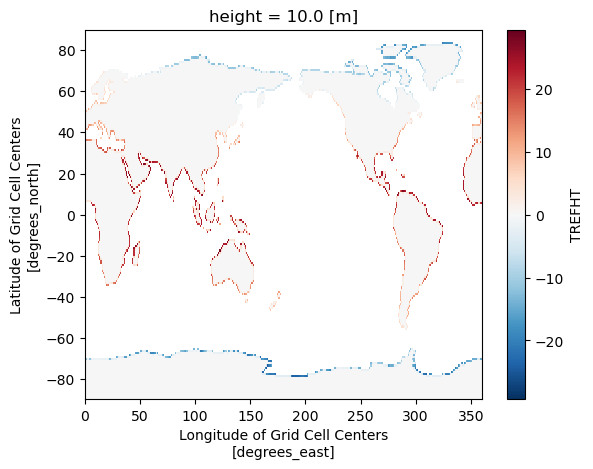

In [8]:
diff = tas_b_regrid_conservative_normed.TREFHT-tas_b_regrid_conservative.TREFHT
diff.plot()

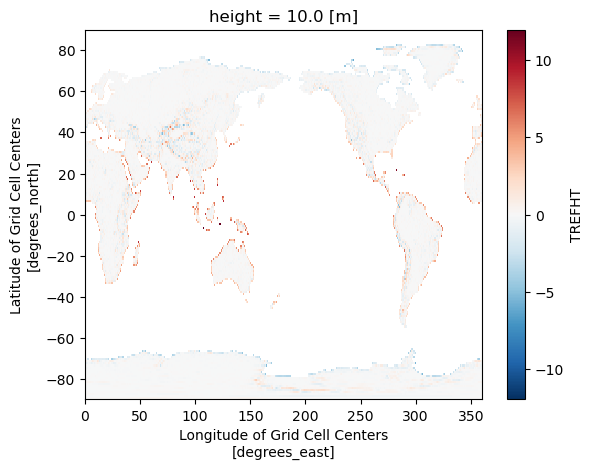

In [9]:
diff_bi_con = tas_b_regrid_bilinear.TREFHT-tas_b_regrid_conservative.TREFHT
diff_bi_con.plot()

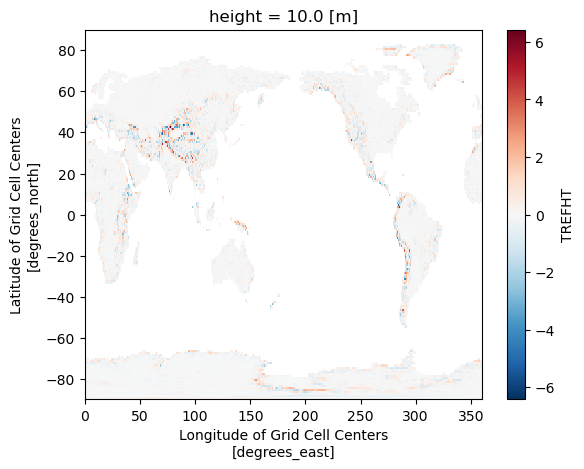

In [10]:
diff_bi_normed = tas_b_regrid_bilinear.TREFHT-tas_b_regrid_conservative_normed.TREFHT
diff_bi_normed.plot()

In [11]:
# Find the index where conservative and conservative_norm diff
#diff_non_zeros = diff.where(diff > 0, drop=True)
data1d = diff.where(diff != 0, drop=True).stack(points=("lat", "lon")).dropna(dim="points")

In [12]:
data1d.points.shape

(3136,)

In [13]:
# Extract data for each lat/lon pair
results = []
for lat, lon in data1d.points.values:
    
    original = tas_b.TREFHT.sel(lat=lat, lon=lon)#, method="nearest")  # Use "nearest" if exact match isn't guaranteed
    bilinear = tas_b_regrid_bilinear.TREFHT.sel(lat=lat, lon=lon)#, method="nearest")  # Use "nearest" if exact match isn't guaranteed
    conserve = tas_b_regrid_conservative.TREFHT.sel(lat=lat, lon=lon)
    normed = tas_b_regrid_conservative_normed.TREFHT.sel(lat=lat, lon=lon)

    #results.append(original_data.item())  # Convert xarray object to a Python scalar
    print('lat,lon,orig,line,cons,normed', lat, lon, original.item(), bilinear.item(),conserve.item(), normed.item() )
print(results)

lat,lon,orig,line,cons,normed -78.5 172.5 -24.493581771850586 -24.493581771850586 -21.808378219604492 -24.59235382080078
lat,lon,orig,line,cons,normed -78.5 173.5 -24.765966415405273 -24.765966415405273 -21.720922470092773 -24.949541091918945
lat,lon,orig,line,cons,normed -78.5 174.5 -25.2132625579834 -25.2132625579834 -21.9981689453125 -25.26799774169922
lat,lon,orig,line,cons,normed -78.5 175.5 -25.51202964782715 -25.51202964782715 -22.200057983398438 -25.499895095825195
lat,lon,orig,line,cons,normed -78.5 176.5 -25.722829818725586 -25.722829818725586 -22.36014175415039 -25.683774948120117
lat,lon,orig,line,cons,normed -78.5 177.5 -25.95699119567871 -25.95699119567871 -22.575992584228516 -25.931711196899414
lat,lon,orig,line,cons,normed -78.5 178.5 -26.156042098999023 -26.156042098999023 -22.799821853637695 -26.188810348510742
lat,lon,orig,line,cons,normed -78.5 179.5 -26.11726951599121 -26.11726951599121 -22.944625854492188 -26.35513687133789
lat,lon,orig,line,cons,normed -78.5 180.

lat,lon,orig,line,cons,normed -66.5 139.5 nan nan -0.2953689992427826 -19.21858787536621
lat,lon,orig,line,cons,normed -66.5 294.5 nan nan -0.18020221590995789 -11.725103378295898
lat,lon,orig,line,cons,normed -66.5 295.5 -13.962072372436523 -13.962072372436523 -9.779192924499512 -12.293981552124023
lat,lon,orig,line,cons,normed -66.5 297.5 -11.828527450561523 -11.828527450561523 -11.33849811553955 -11.521462440490723
lat,lon,orig,line,cons,normed -66.5 298.5 -11.481695175170898 -11.481695175170898 -9.10556697845459 -11.680314064025879
lat,lon,orig,line,cons,normed -66.5 299.5 nan nan -0.173106849193573 -11.263433456420898
lat,lon,orig,line,cons,normed -65.5 98.5 nan nan -0.22523486614227295 -14.642644882202148
lat,lon,orig,line,cons,normed -65.5 99.5 nan nan -1.6060396432876587 -14.86761474609375
lat,lon,orig,line,cons,normed -65.5 102.5 nan nan -1.2853291034698486 -13.874366760253906
lat,lon,orig,line,cons,normed -65.5 295.5 nan nan -0.18992753326892853 -12.347295761108398
lat,lon,or

lat,lon,orig,line,cons,normed -13.5 135.5 26.157922744750977 26.157922744750977 23.075448989868164 26.371889114379883
lat,lon,orig,line,cons,normed -13.5 142.5 26.38738441467285 26.38738441467285 20.024930953979492 26.151819229125977
lat,lon,orig,line,cons,normed -13.5 143.5 24.94829750061035 24.94829750061035 19.258758544921875 25.151226043701172
lat,lon,orig,line,cons,normed -13.5 283.5 nan nan 0.23220640420913696 14.845209121704102
lat,lon,orig,line,cons,normed -13.5 284.5 11.962976455688477 11.962976455688477 9.226789474487305 10.359687805175781
lat,lon,orig,line,cons,normed -13.5 320.5 23.051843643188477 23.051843643188477 20.495878219604492 23.012435913085938
lat,lon,orig,line,cons,normed -13.5 321.5 nan nan 0.38723859190940857 24.7565860748291
lat,lon,orig,line,cons,normed -12.5 13.5 nan nan 4.848935604095459 22.155223846435547
lat,lon,orig,line,cons,normed -12.5 40.5 nan nan 3.0584018230438232 24.467565536499023
lat,lon,orig,line,cons,normed -12.5 130.5 nan nan 0.42516648769378

lat,lon,orig,line,cons,normed 14.5 79.5 28.548181533813477 28.548181533813477 25.231327056884766 28.3304500579834
lat,lon,orig,line,cons,normed 14.5 80.5 nan nan 0.4421353042125702 28.33049964904785
lat,lon,orig,line,cons,normed 14.5 98.5 24.2852725982666 24.2852725982666 19.388202667236328 24.813194274902344
lat,lon,orig,line,cons,normed 14.5 108.5 21.525720596313477 21.525720596313477 17.646581649780273 22.591222763061523
lat,lon,orig,line,cons,normed 14.5 120.5 26.727075576782227 26.727075576782227 17.615840911865234 26.838346481323242
lat,lon,orig,line,cons,normed 14.5 267.5 nan nan 0.28618720173835754 18.3378849029541
lat,lon,orig,line,cons,normed 14.5 268.5 nan nan 1.9455121755599976 15.55305290222168
lat,lon,orig,line,cons,normed 14.5 269.5 18.8059024810791 18.8059024810791 15.79427719116211 20.214611053466797
lat,lon,orig,line,cons,normed 14.5 270.5 21.7044620513916 21.7044620513916 21.780731201171875 22.126867294311523
lat,lon,orig,line,cons,normed 14.5 275.5 25.02413368225097

lat,lon,orig,line,cons,normed 36.5 3.5 nan nan 1.9663563966751099 15.724335670471191
lat,lon,orig,line,cons,normed 36.5 4.5 nan nan 1.9874194860458374 15.892769813537598
lat,lon,orig,line,cons,normed 36.5 5.5 nan nan 3.396515130996704 15.523202896118164
lat,lon,orig,line,cons,normed 36.5 6.5 16.566003799438477 16.566003799438477 14.316624641418457 16.360788345336914
lat,lon,orig,line,cons,normed 36.5 7.5 17.33989906311035 17.33989906311035 14.814826011657715 16.930126190185547
lat,lon,orig,line,cons,normed 36.5 8.5 16.725671768188477 16.725671768188477 15.029979705810547 17.176000595092773
lat,lon,orig,line,cons,normed 36.5 9.5 18.218042373657227 18.218042373657227 15.754195213317871 18.003620147705078
lat,lon,orig,line,cons,normed 36.5 10.5 nan nan 2.046095132827759 18.696176528930664
lat,lon,orig,line,cons,normed 36.5 28.5 nan nan 0.22876377403736115 14.701196670532227
lat,lon,orig,line,cons,normed 36.5 29.5 nan nan 1.488080382347107 11.910079956054688
lat,lon,orig,line,cons,normed 3

lat,lon,orig,line,cons,normed 58.5 224.5 4.304925441741943 4.304925441741943 3.896723747253418 3.9592666625976562
lat,lon,orig,line,cons,normed 58.5 265.5 nan nan -1.4345157146453857 -6.1005988121032715
lat,lon,orig,line,cons,normed 58.5 266.5 nan nan -0.664977490901947 -6.037512302398682
lat,lon,orig,line,cons,normed 58.5 282.5 -6.197424411773682 -6.197424411773682 -4.140803337097168 -6.164434432983398
lat,lon,orig,line,cons,normed 58.5 283.5 -6.384588718414307 -6.384588718414307 -6.308831214904785 -6.410088539123535
lat,lon,orig,line,cons,normed 58.5 290.5 -5.884283542633057 -5.884283542633057 -5.124906063079834 -5.753188133239746
lat,lon,orig,line,cons,normed 58.5 291.5 nan nan -0.5915393829345703 -4.697084903717041
lat,lon,orig,line,cons,normed 58.5 292.5 nan nan -0.6000899076461792 -4.764980316162109
lat,lon,orig,line,cons,normed 58.5 293.5 -4.925421237945557 -4.925421237945557 -4.0283918380737305 -5.150015354156494
lat,lon,orig,line,cons,normed 58.5 294.5 -5.920324802398682 -5.92

lat,lon,orig,line,cons,normed 69.5 229.5 -9.136419296264648 -9.136419296264648 -7.908565998077393 -9.01649284362793
lat,lon,orig,line,cons,normed 69.5 230.5 nan nan -1.9909178018569946 -9.015079498291016
lat,lon,orig,line,cons,normed 69.5 231.5 nan nan -2.0599708557128906 -9.3277587890625
lat,lon,orig,line,cons,normed 69.5 232.5 -9.564458847045898 -9.564458847045898 -8.491315841674805 -9.68088150024414
lat,lon,orig,line,cons,normed 69.5 233.5 -10.301733016967773 -10.301733016967773 -8.918664932250977 -10.168098449707031
lat,lon,orig,line,cons,normed 69.5 234.5 -9.956701278686523 -9.956701278686523 -8.834625244140625 -10.072285652160645
lat,lon,orig,line,cons,normed 69.5 235.5 -9.974096298217773 -9.974096298217773 -7.891744613647461 -10.074121475219727
lat,lon,orig,line,cons,normed 69.5 236.5 nan nan -1.3352378606796265 -10.506328582763672
lat,lon,orig,line,cons,normed 69.5 237.5 nan nan -1.425601840019226 -11.217358589172363
lat,lon,orig,line,cons,normed 69.5 238.5 nan nan -1.506775021

lat,lon,orig,line,cons,normed 83.5 331.5 nan nan -2.627046823501587 -19.72199058532715
lat,lon,orig,line,cons,normed 83.5 332.5 nan nan -2.576049327850342 -19.33913803100586
lat,lon,orig,line,cons,normed 83.5 333.5 nan nan -2.1938085556030273 -18.82485008239746
[]


In [14]:
def print_stats(arr1, arr2, label1="Array 1", label2="Array 2"):
    stats = {
        "Min": (np.min(arr1), np.min(arr2)),
        "Max": (np.max(arr1), np.max(arr2)),
        "Mean": (np.mean(arr1), np.mean(arr2)),
        "Std": (np.std(arr1), np.std(arr2)),
    }
    
    print(f"{'Stat':<10} {label1:<15} {label2:<15}")
    print("-" * 40)
    for stat, values in stats.items():
        print(f"{stat:<10} {values[0]:<15.6f} {values[1]:<15.6f}")

In [15]:
print_stats(tas_b.TREFHT, tas_b_regrid_conservative.TREFHT)

Stat       Array 1         Array 2        
----------------------------------------
Min        -53.482216      -53.193939     
Max        33.916008       31.726822      
Mean       -5.335422       -4.895763      
Std        25.083681       24.112719      


In [16]:
print_stats(tas_b.TREFHT, tas_b_regrid_conservative_normed.TREFHT)

Stat       Array 1         Array 2        
----------------------------------------
Min        -53.482216      -53.193939     
Max        33.916008       31.726822      
Mean       -5.335422       -4.591918      
Std        25.083681       24.693712      


In [17]:
print_stats(tas_b.TREFHT, tas_b_regrid_bilinear.TREFHT)

Stat       Array 1         Array 2        
----------------------------------------
Min        -53.482216      -53.426811     
Max        33.916008       33.560753      
Mean       -5.335422       -5.211089      
Std        25.083681       25.030613      
